In [121]:
import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

from __future__ import unicode_literals

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer
from PyHEADTAIL_feedback.feedback import IdealBunchFeedback, IdealSliceFeedback, OneboxFeedback
from PyHEADTAIL_feedback.processors import PhaseLinearizedLowpass, ChargeWeighter, LowpassFilter
from PyHEADTAIL_feedback.processors import EdgeWeighter, VectorSumRegister, PickUpProcessor

np.random.seed(0)

In [122]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [123]:
def track(n_turns, bunch, total_map, bunch_dump):
    
    for i in xrange(n_turns):
        bunch_dump.dump()
        
        for m_ in total_map:
            m_.track(bunch)

In [124]:
class BunchTracker(object):
    def __init__(self,bunch):
        self.counter = 0

        self.bunch = bunch
        self.turn = np.array([])

        self.mean_x = np.array([])
        self.mean_y = np.array([])
        self.mean_z = np.array([])

        self.mean_xp = np.array([])
        self.mean_yp = np.array([])
        self.mean_dp = np.array([])

        self.sigma_x = np.array([])
        self.sigma_y = np.array([])
        self.sigma_z = np.array([])

        self.sigma_xp = np.array([])
        self.sigma_yp = np.array([])
        self.sigma_dp = np.array([])

        self.epsn_x = np.array([])
        self.epsn_y = np.array([])
        self.epsn_z = np.array([])

    def dump(self):
        self.turn=np.append(self.turn,[self.counter])
        self.counter += 1

        self.mean_x=np.append(self.mean_x,[self.bunch.mean_x()])
        self.mean_y=np.append(self.mean_y,[self.bunch.mean_y()])
        self.mean_z=np.append(self.mean_z,[self.bunch.mean_z()])

        self.mean_xp=np.append(self.mean_xp,[self.bunch.mean_xp()])
        self.mean_yp=np.append(self.mean_yp,[self.bunch.mean_yp()])
        self.mean_dp=np.append(self.mean_dp,[self.bunch.mean_dp()])

        self.sigma_x=np.append(self.sigma_x,[self.bunch.sigma_x()])
        self.sigma_y=np.append(self.sigma_y,[self.bunch.sigma_y()])
        self.sigma_z=np.append(self.sigma_z,[self.bunch.sigma_z()])

        self.sigma_xp=np.append(self.sigma_xp,[self.bunch.sigma_xp()])
        self.sigma_yp=np.append(self.sigma_yp,[self.bunch.sigma_yp()])
        self.sigma_dp=np.append(self.sigma_dp,[self.bunch.sigma_dp()])

        self.epsn_x = np.append(self.epsn_x,[self.bunch.epsn_x()])
        self.epsn_y = np.append(self.epsn_y,[self.bunch.epsn_y()])
        self.epsn_z = np.append(self.epsn_z,[self.bunch.epsn_z()])

In [125]:
def compare_traces(trackers,labels):
    fig = plt.figure(figsize=(16, 8))
    ax_x_mean = fig.add_subplot(231)
    ax_x_sigma = fig.add_subplot(232)
    ax_x_epsn = fig.add_subplot(233)
    
    for i,tracker in enumerate(trackers):
        ax_x_mean.plot(tracker.turn, tracker.mean_x*1000, label=labels[i])
    ax_x_mean.legend(loc='upper right')
    ax_x_mean.set_ylabel('<x> [mm]')
    ax_x_mean.ticklabel_format(useOffset=False)
    
    for i,tracker in enumerate(trackers):
        ax_x_sigma.plot(tracker.turn, tracker.sigma_x*1000, label=labels[i])
    ax_x_sigma.set_ylabel('sigma_x [mm]')
    ax_x_sigma.ticklabel_format(useOffset=False)
    
    for i,tracker in enumerate(trackers):
        ax_x_epsn.plot(tracker.turn, tracker.epsn_x*1e6, label=labels[i])
    ax_x_epsn.set_ylabel('epsn_x [mm mrad]')
    ax_x_epsn.set_xlabel('Turn')
    ax_x_epsn.ticklabel_format(useOffset=False)
    
    ax_y_mean = fig.add_subplot(234)
    ax_y_sigma = fig.add_subplot(235)
    ax_y_epsn = fig.add_subplot(236)
    
    for i,tracker in enumerate(trackers):
        ax_y_mean.plot(tracker.turn, tracker.mean_y*1000, label=labels[i])
    ax_y_mean.legend(loc='upper right')
    ax_y_mean.set_ylabel('<y> [mm]')
    ax_y_mean.ticklabel_format(useOffset=False)
    
    for i,tracker in enumerate(trackers):
        ax_y_sigma.plot(tracker.turn, tracker.sigma_y*1000, label=labels[i])
    ax_y_sigma.set_ylabel('sigma_y [mm]')
    ax_y_sigma.ticklabel_format(useOffset=False)
    
    for i,tracker in enumerate(trackers):
        ax_y_epsn.plot(tracker.turn, tracker.epsn_y*1e6, label=labels[i])
    ax_y_epsn.set_ylabel('epsn_y  [mm mrad]')
    ax_y_epsn.set_xlabel('Turn')
    ax_y_epsn.ticklabel_format(useOffset=False)

    plt.show()

In [126]:
def compare_projections(bunches, labels):
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle('z-x and z-y projections of bunches', fontsize=14, fontweight='bold')
    ax_z_x = fig.add_subplot(121)
    ax_z_y = fig.add_subplot(122)
    
    for i,bunch in enumerate(bunches):
        ax_z_x.plot(bunch.z, bunch.x*1000,'.', label=labels[i])
    ax_z_x.legend(loc='upper right')
    ax_z_x.set_xlabel('z [m]')
    ax_z_x.set_ylabel('x [mm]')
    for i,bunch in enumerate(bunches):
        ax_z_y.plot(bunch.z, bunch.y*1000,'.', label=labels[i])
    ax_z_y.legend(loc='upper right')
    ax_z_y.set_xlabel('z [m]')
    ax_z_y.set_ylabel('y [mm]')

### Basic parameters

In [127]:
n_turns = 2500
n_segments = 5
n_macroparticles = 10000

feedback_gain = 0.1

Q_x = 64.28
Q_y = 59.31
Q_s = 0.000000000001
#Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]

### Transverse and longitunal maps

In [128]:
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
    
alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)
        
trans_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
long_map = LinearMap(alpha_0, C, Q_s)

### Kicked bunch

In [129]:
bunch_ref = generate_bunch(n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,long_map)

n_sigma_z = 3
n_slices = 15
z_cuts=(-0.25,0.25)
#slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

slicer = UniformBinSlicer(n_slices, z_cuts=z_cuts)

slice_set = bunch_ref.get_slices(slicer, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks for each slice
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

## Reference traces from ideal feedbacks

In [130]:
bunch_IdealBunchFB = copy.deepcopy(bunch_ref)
tracker_IdealBunchFB = BunchTracker(bunch_IdealBunchFB)
feedback_map = IdealBunchFeedback(feedback_gain)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_IdealBunchFB,total_map_FB,tracker_IdealBunchFB)

bunch_IdealSliceFB = copy.deepcopy(bunch_ref)
tracker_IdealSliceFB = BunchTracker(bunch_IdealSliceFB)
feedback_map = IdealSliceFeedback(feedback_gain,slicer)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_IdealSliceFB,total_map_FB,tracker_IdealSliceFB)

## Realistic feedback systems

There are multiple ways to implement a feedback system for which two are presented here as examples. Generally the simples feedback system can be divided to three parts: a pickup, a delay generator and a kicker. The pickup and the kicker have finite bandwidths, which can be modeled by using low pass filters. The delay generator is required because signal processing takes typically one turn in which time bunch is rotated in the phase space.

In the reality, there are some problems with the linearity of the pickup signal. The pickup signal is proportional to both displacement and charge of the beam but, however, the correction for the beam is only proportional to displacement. In order to get the correct displacement signal, two approaches have been used. If a bunch length and a shape of the charge distribution is known, the signal on the edge of the bunch can be artificially weighted. This is demonstrated in CASE I. The other method is to calculate a ratio of a difference and a sum signal of the two plate pickup system.  It gives the correct displacement in the limits of banwidth and signal strength (CASE II).

In the systems, which are pushing the limits of the technology, the bandwidth of the kicker has been extended by phase linearizing the signal. This can be modeled by using PhaseLinearizedLowpass filter, which is used in both examples.




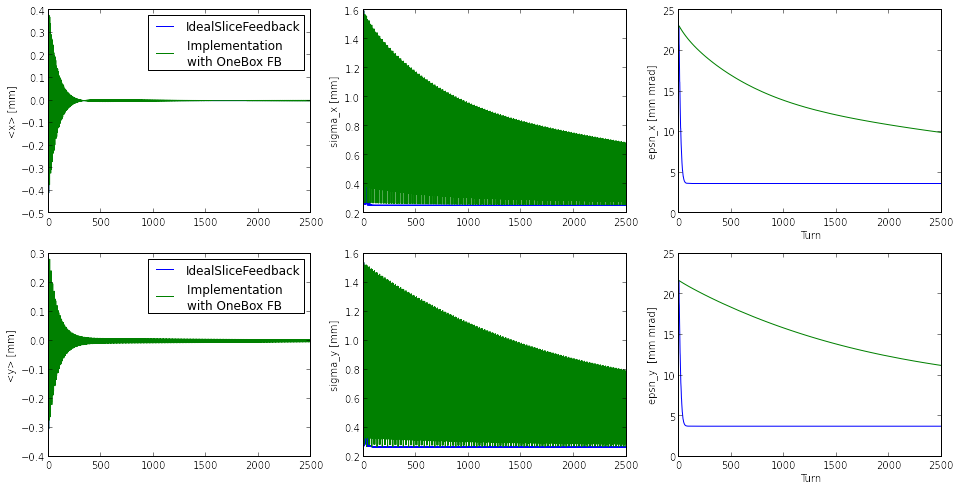

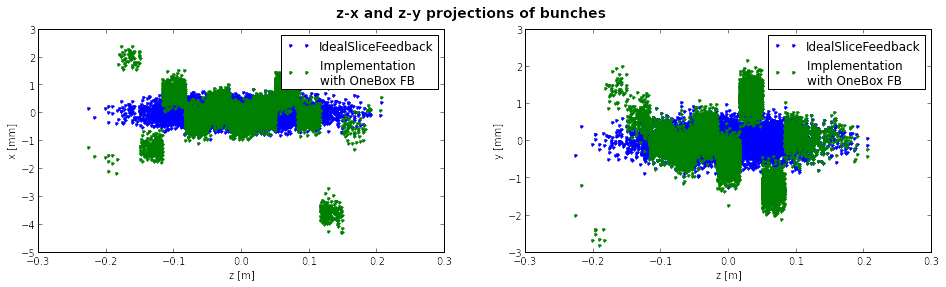

In [131]:
# CASE I
# Signals go through five processors:
# ChargeWeighter(): Pickup signal is weighted with beam current (charge). The maximum weight is normalized to be one.
# LowpassFilter(f_c): Simulates an analog bandwidth of a pick up.
# VectorSumRegister(delay, n_avg, omega): Simulates delay and averaging of the signal. Input paremeters are delay [turn], 
#               a length of the averaging window [turn] and a betatron phase shift per turn (omega) [rad]. The total 
#               length of the register is delay + n_avg
# EdgeWeighter(bunch_length,bunch_decay_length,maximum_weight): Because of the charge weighting, 
#               the kick on edges of the bunch is weaker than on the middle of the bunch. This processor is used to 
#               amplify signal on the edges.
#               The input parameters are an estimated bunch length (bunch_length) [m], a bunch decay length on the edge 
#               of the bunch  (bunch_decay_length) [m] and a maximum weight amplification outside of the bunch 
#               (maximum_weight) 
# PhaseLinearizedLowpass(f_c_kicker): Simulates bandwidth of the kicker

bunch_fast_FB = copy.deepcopy(bunch_ref)
tracker_fast_FB = BunchTracker(bunch_fast_FB)

#Cut off frequencies of the pickup and the kicker
f_c_pickup = 1500e6
f_c_kicker = 100e6

# parameters for the register:
# betatron phase shifts per turn
omega_x = 2.*pi*Q_x
omega_y = 2.*pi*Q_y
# delay [turns]
n_delay = 1
# number of turns averaged
n_avg = 2

# parameters for the inverse weighter
bunch_length = 0.2
bunch_decay_length = 0.1
maximum_weight = 150

signal_processors_x = [ChargeWeighter(),
                       LowpassFilter(f_c_pickup),
                       VectorSumRegister(n_delay,n_avg,omega_x),
                       EdgeWeighter(bunch_length,bunch_decay_length,maximum_weight),
                       PhaseLinearizedLowpass(f_c_kicker)]

signal_processors_y = [ChargeWeighter(),
                       LowpassFilter(f_c_pickup),
                       VectorSumRegister(n_delay,n_avg,omega_y),
                       EdgeWeighter(bunch_length,bunch_decay_length,maximum_weight),
                       PhaseLinearizedLowpass(f_c_kicker)]

feedback_map = OneboxFeedback(feedback_gain,slicer,signal_processors_x,signal_processors_y)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_fast_FB,total_map_FB,tracker_fast_FB)

compare_traces([tracker_IdealSliceFB,tracker_fast_FB], ['IdealSliceFeedback', 'Implementation \nwith OneBox FB'])
compare_projections([bunch_IdealSliceFB, bunch_fast_FB], ['IdealSliceFeedback', 'Implementation \nwith OneBox FB'])

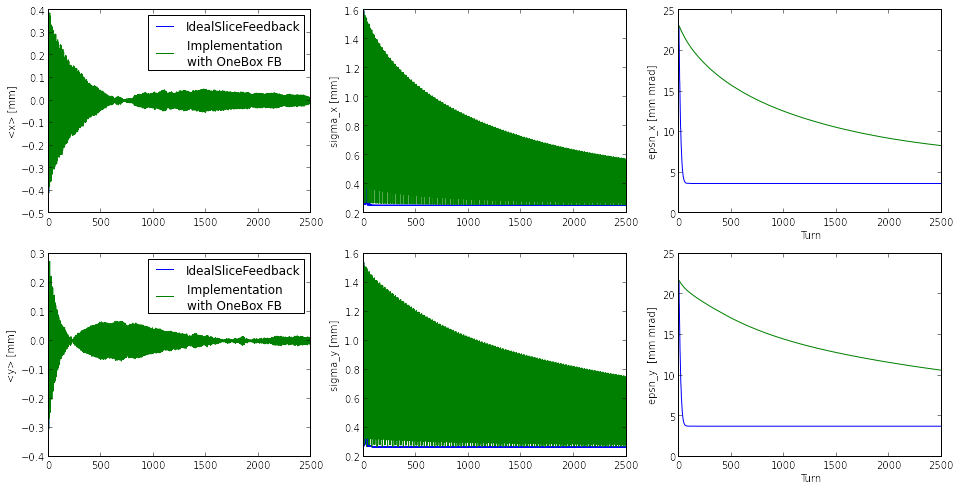

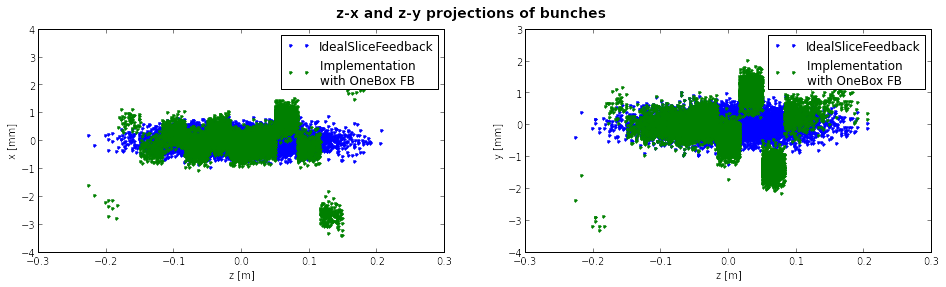

In [132]:
# CASE II
# This example is similar to CASE I, but it uses a signalprocessor PickUpProcessor to emulate a two plates pickup, where
# signal is a ratio of a difference and a sum signals from the plates. 

# PickUpProcessor(RMS_noise,f_cutoff, threshold, reference) requires three input parameters:
# RMS_noise: an absulute RMS noise level for one plate in units of the input signal [m] or [m rad].
# f_cutoff: a cut off frequency for low pass filter in one plate
# threshold: a relative signal level from the reference signal level below which the singal is set to be zero
# reference: a reference signal level, when the beam moves in the middle of the beam tube [in the units of input signal]

bunch_fast_FB = copy.deepcopy(bunch_ref)
tracker_fast_FB = BunchTracker(bunch_fast_FB)

#Cut off frequencies of the pickup and the kicker
f_c_pickup = 1500e6
f_c_kicker = 100e6

# parameters for the register:
# betatron phase shifts per turn
omega_x = 2.*pi*Q_x
omega_y = 2.*pi*Q_y
# delay [turns]
n_delay = 1
# number of turns averaged
n_avg = 2

# parameters for the inverse weighter
# parameters for the inverse weighter
bunch_length = 0.2
bunch_decay_length = 0.1
maximum_weight = 10

noise_level = 0.01e-3
threshold_level = 1e-2
reference_level = 1e-3

signal_processors_x = [PickUpProcessor(noise_level,f_c_pickup,threshold_level,reference_level),
                       VectorSumRegister(n_delay,n_avg,omega_x),
                       PhaseLinearizedLowpass(f_c_kicker)
                      ]

signal_processors_y = [PickUpProcessor(noise_level,f_c_pickup,threshold_level,reference_level),
                       VectorSumRegister(n_delay,n_avg,omega_y),
                       PhaseLinearizedLowpass(f_c_kicker)
                      ]

feedback_map = OneboxFeedback(feedback_gain,slicer,signal_processors_x,signal_processors_y,'displacement')
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_fast_FB,total_map_FB,tracker_fast_FB)

compare_traces([tracker_IdealSliceFB,tracker_fast_FB], ['IdealSliceFeedback', 'Implementation \nwith OneBox FB'])
compare_projections([bunch_IdealSliceFB, bunch_fast_FB], ['IdealSliceFeedback', 'Implementation \nwith OneBox FB'])